In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GroupKFold
from concurrent.futures import ProcessPoolExecutor, as_completed

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 最大表示行数の指定（ここでは50行を指定）
pd.set_option('display.max_rows', 500)

In [2]:
train_df = pd.read_parquet('../data/feature_engineering_v10_train_df.parquet')
test_df = pd.read_parquet('../data/feature_engineering_v10_test_df.parquet')

train_label = pd.read_csv('../train_label.csv')
test_session = pd.read_csv('../test_session.csv')

train_log = pd.read_csv('../train_log.csv')
test_log = pd.read_csv('../test_log.csv')

In [3]:
train_df

,session_id,yado_no,target,predict_no,seq_no,seen_yad,max_seq_no,diff_seq_no,is_odd,multiple_visits_flag,yad_type,total_room_cnt,wireless_lan_flg,onsen_flg,kd_stn_5min,kd_bch_5min,kd_slp_5min,kd_conv_walk_5min,wid_cd,ken_cd,lrg_cd,sml_cd,popularity,overall_rank,wid_cd_rank,ken_cd_rank,lrg_cd_rank,sml_cd_rank,label_wid_cd,label_ken_cd,label_lrg_cd,label_sml_cd,count_wid_cd,count_ken_cd,count_lrg_cd,count_sml_cd,count_yado_no,fold,TE_wid_cd_mean,TE_wid_cd_var,TE_ken_cd_mean,TE_ken_cd_var,TE_lrg_cd_mean,TE_lrg_cd_var,TE_sml_cd_mean,TE_sml_cd_var,TE_yado_no_mean,TE_yado_no_var
0,000125c737df1802b6e365f93c96d3c8,7531,0,0,-1,0,0,-1,-1,0,0,97.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,132.0,1158.5,33.0,10.0,10.0,7.0,5,12,15,19,97420,28008,22512,15711,953,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.028802,0.028005
1,000125c737df1802b6e365f93c96d3c8,441,0,1,-1,0,0,-1,-1,0,0,314.0,1.0,0,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,161.0,714.5,16.0,7.0,7.0,4.0,5,12,15,19,97420,28008,22512,15711,958,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.032295,0.031288
2,000125c737df1802b6e365f93c96d3c8,2480,0,2,-1,0,0,-1,-1,0,0,144.0,1.0,0,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,142.0,961.5,23.0,9.0,9.0,6.0,5,12,15,19,97420,28008,22512,15711,941,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.028136,0.027376
3,000125c737df1802b6e365f93c96d3c8,13240,0,3,-1,0,0,-1,-1,0,0,150.0,1.0,1,1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,123.0,1340.0,38.0,11.0,11.0,8.0,5,12,15,19,97420,28008,22512,15711,558,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.027888,0.027165
4,000125c737df1802b6e365f93c96d3c8,10378,1,4,-1,0,0,-1,-1,0,0,264.0,1.0,1,-1.0,-1.0,-1.0,1.0,43875109d1dab93592812c50d18270a7,3b09a7ce9934c00fd266f9cf246308d1,c0e203c17b3a418d089e96aac011d1a1,a5a49a911ded94700d282a1d4ff3a373,109.0,1679.5,47.0,15.0,15.0,10.0,5,12,15,19,97420,28008,22512,15711,474,0,0.037534,0.036126,0.042687,0.040867,0.034700,0.033498,0.031581,0.030586,0.035129,0.033974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,0,5,-1,0,2,-1,-1,0,1,-1.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,50.0,4353.0,509.0,63.0,25.0,7.0,4,24,148,227,335580,38742,11787,2856,209,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.040404,0.038787,0.016129,0.015955
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,0,6,-1,0,2,-1,-1,0,0,198.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,e5680545edc53d20bb05168e67c9f9f0,138.0,1039.0,136.0,18.0,11.0,5.0,4,24,148,227,335580,38742,11787,2856,338,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.040404,0.038787,0.019737,0.019411
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,0,7,-1,0,2,-1,-1,0,0,94.0,1.0,1,-1.0,-1.0,-1.0,-1.0,e9316013ee1b03f4525fe361c46ce9c5,517061b8165aa6370d9025951a64aa52,7e5ebb4d5e3cdfd3ad3798c9864d87d6,840f2157ec5bb4f5501a3ace2f4ef8d1,120.0,1408.0,193.0,27.0,15.0,9.0,4,24,148,228,335580,38742,11787,8931,555,9,0.034683,0.033480,0.040933,0.039258,0.037473,0.036072,0.036554,0.035222,0.025794,0.025178
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,0,8,-1,0,2,-1,-1,0,0,310.0,1.0,0,-1.0,-1.0,-1.0,-1.0,e9316013

In [4]:
print(train_df['seen_yad'].value_counts())
print(test_df['seen_yad'].value_counts())

0    2777527
Name: seen_yad, dtype: int64
0    1683604
Name: seen_yad, dtype: int64


### CatBoost Ranker

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import label_ranking_average_precision_score
from catboost import CatBoostRanker, Pool

# 特徴量とターゲットの定義
all_features = train_df.columns.to_list()
features= [x for x in all_features if x not in ('session_id', 'fold', 'target', 'wid_cd', 'ken_cd', 'lrg_cd', 'sml_cd', 'seen_yad', 'TE_wid_cd', 'TE_ken_cd', 'TE_lrg_cd', 'TE_sml_cd', 'TE_yado_no')] # seen_yadも入れる 
cat_cols = ['yado_no']+ ['label_wid_cd', 'label_ken_cd', 'label_lrg_cd', 'label_sml_cd'] 
target = 'target'  # ターゲット変数の列名
query_ids =  'session_id' #train_df['session_id'].values  # クエリIDの列名

# CatBoost のパラメータ
params = {
    'loss_function': 'YetiRank',  # YetiRankPairwise という選択肢もあります
    'learning_rate': 0.2,
    'iterations': 5000,
    'depth': 6,
    'random_seed': 42531,
    "cat_features": cat_cols,
    'task_type': 'GPU',  # GPUを使用するための設定
}

In [6]:
map_scores = []  # 各foldのMAPスコアを保存するリスト
test_pred = []   # 各foldのテストデータの予測値を保存するリスト
oof_pred = np.zeros(len(train_df))  # OOF予測値用の配列を初期化

for fold in range(10):
    # トレーニングデータとバリデーションデータの分割
    train_data = train_df[train_df['fold'] != fold]
    valid_data = train_df[train_df['fold'] == fold]

    # データセットの作成
    train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids], cat_features=cat_cols)
    val_pool = Pool(data=valid_data[features], label=valid_data[target], group_id=valid_data[query_ids], cat_features=cat_cols)

    # モデルの訓練
    model = CatBoostRanker(**params)
    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=True)

    # バリデーションデータでの予測と評価
    valid_pred = model.predict(val_pool)
    oof_pred[valid_data.index] = valid_pred  # OOF予測値の保存

    # MAPスコアの計算
    map_score = label_ranking_average_precision_score([valid_data[target].values], [valid_pred])
    map_scores.append(map_score)
    print(f'Fold {fold}: MAP = {map_score}')

    # テストデータでの予測
    test_pred.append(model.predict(test_df[features]))

# 平均 MAP の計算
print(f'Mean MAP: {np.mean(map_scores)}')


Groupwise loss function. OneHotMaxSize set to 10


Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1955965	best: 0.1955965 (0)	total: 133ms	remaining: 11m 2s
1:	test: 0.1999719	best: 0.1999719 (1)	total: 256ms	remaining: 10m 39s
2:	test: 0.2000144	best: 0.2000144 (2)	total: 376ms	remaining: 10m 25s
3:	test: 0.2105406	best: 0.2105406 (3)	total: 495ms	remaining: 10m 18s
4:	test: 0.2109026	best: 0.2109026 (4)	total: 613ms	remaining: 10m 12s
5:	test: 0.2113326	best: 0.2113326 (5)	total: 736ms	remaining: 10m 12s
6:	test: 0.2126634	best: 0.2126634 (6)	total: 856ms	remaining: 10m 10s
7:	test: 0.2152446	best: 0.2152446 (7)	total: 975ms	remaining: 10m 8s
8:	test: 0.2155484	best: 0.2155484 (8)	total: 1.09s	remaining: 10m 5s
9:	test: 0.2156242	best: 0.2156242 (9)	total: 1.21s	remaining: 10m 3s
10:	test: 0.2166220	best: 0.2166220 (10)	total: 1.33s	remaining: 10m 3s
11:	test: 0.2170703	best: 0.2170703 (11)	total: 1.45s	remaining: 10m 2s
12:	test: 0.2173558	best: 0.2173558 (12)	total: 1.57s	remaining: 10m 1s
13:	test: 0.2174458	best: 0.2174458 (13)	total: 1.69s	remaining: 10m
14:	test:

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1989524	best: 0.1989524 (0)	total: 124ms	remaining: 10m 18s
1:	test: 0.2023078	best: 0.2023078 (1)	total: 246ms	remaining: 10m 14s
2:	test: 0.2022929	best: 0.2023078 (1)	total: 361ms	remaining: 10m
3:	test: 0.2141459	best: 0.2141459 (3)	total: 477ms	remaining: 9m 55s
4:	test: 0.2140073	best: 0.2141459 (3)	total: 592ms	remaining: 9m 51s
5:	test: 0.2146051	best: 0.2146051 (5)	total: 708ms	remaining: 9m 48s
6:	test: 0.2146557	best: 0.2146557 (6)	total: 825ms	remaining: 9m 48s
7:	test: 0.2158093	best: 0.2158093 (7)	total: 941ms	remaining: 9m 47s
8:	test: 0.2173757	best: 0.2173757 (8)	total: 1.06s	remaining: 9m 45s
9:	test: 0.2203604	best: 0.2203604 (9)	total: 1.17s	remaining: 9m 45s
10:	test: 0.2203051	best: 0.2203604 (9)	total: 1.29s	remaining: 9m 44s
11:	test: 0.2206503	best: 0.2206503 (11)	total: 1.41s	remaining: 9m 44s
12:	test: 0.2210973	best: 0.2210973 (12)	total: 1.52s	remaining: 9m 43s
13:	test: 0.2210057	best: 0.2210973 (12)	total: 1.64s	remaining: 9m 43s
14:	test: 0.22

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1937236	best: 0.1937236 (0)	total: 123ms	remaining: 10m 12s
1:	test: 0.1973409	best: 0.1973409 (1)	total: 243ms	remaining: 10m 7s
2:	test: 0.2083355	best: 0.2083355 (2)	total: 361ms	remaining: 10m
3:	test: 0.2085852	best: 0.2085852 (3)	total: 476ms	remaining: 9m 53s
4:	test: 0.2088119	best: 0.2088119 (4)	total: 593ms	remaining: 9m 52s
5:	test: 0.2109451	best: 0.2109451 (5)	total: 710ms	remaining: 9m 50s
6:	test: 0.2109846	best: 0.2109846 (6)	total: 826ms	remaining: 9m 49s
7:	test: 0.2127129	best: 0.2127129 (7)	total: 943ms	remaining: 9m 48s
8:	test: 0.2145216	best: 0.2145216 (8)	total: 1.06s	remaining: 9m 46s
9:	test: 0.2145942	best: 0.2145942 (9)	total: 1.17s	remaining: 9m 46s
10:	test: 0.2153646	best: 0.2153646 (10)	total: 1.29s	remaining: 9m 45s
11:	test: 0.2158287	best: 0.2158287 (11)	total: 1.41s	remaining: 9m 44s
12:	test: 0.2160214	best: 0.2160214 (12)	total: 1.52s	remaining: 9m 44s
13:	test: 0.2162727	best: 0.2162727 (13)	total: 1.64s	remaining: 9m 44s
14:	test: 0.21

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1961236	best: 0.1961236 (0)	total: 123ms	remaining: 10m 15s
1:	test: 0.2126091	best: 0.2126091 (1)	total: 246ms	remaining: 10m 15s
2:	test: 0.2126443	best: 0.2126443 (2)	total: 364ms	remaining: 10m 6s
3:	test: 0.2127852	best: 0.2127852 (3)	total: 480ms	remaining: 9m 59s
4:	test: 0.2128596	best: 0.2128596 (4)	total: 596ms	remaining: 9m 55s
5:	test: 0.2142907	best: 0.2142907 (5)	total: 713ms	remaining: 9m 53s
6:	test: 0.2143262	best: 0.2143262 (6)	total: 830ms	remaining: 9m 51s
7:	test: 0.2145571	best: 0.2145571 (7)	total: 949ms	remaining: 9m 52s
8:	test: 0.2161528	best: 0.2161528 (8)	total: 1.07s	remaining: 9m 53s
9:	test: 0.2163677	best: 0.2163677 (9)	total: 1.19s	remaining: 9m 51s
10:	test: 0.2179290	best: 0.2179290 (10)	total: 1.3s	remaining: 9m 50s
11:	test: 0.2185997	best: 0.2185997 (11)	total: 1.42s	remaining: 9m 49s
12:	test: 0.2187871	best: 0.2187871 (12)	total: 1.54s	remaining: 9m 49s
13:	test: 0.2195480	best: 0.2195480 (13)	total: 1.65s	remaining: 9m 48s
14:	test: 0

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1965908	best: 0.1965908 (0)	total: 125ms	remaining: 10m 23s
1:	test: 0.2132464	best: 0.2132464 (1)	total: 242ms	remaining: 10m 5s
2:	test: 0.2131950	best: 0.2132464 (1)	total: 358ms	remaining: 9m 56s
3:	test: 0.2131291	best: 0.2132464 (1)	total: 474ms	remaining: 9m 51s
4:	test: 0.2134299	best: 0.2134299 (4)	total: 590ms	remaining: 9m 49s
5:	test: 0.2159262	best: 0.2159262 (5)	total: 705ms	remaining: 9m 46s
6:	test: 0.2167010	best: 0.2167010 (6)	total: 822ms	remaining: 9m 46s
7:	test: 0.2181649	best: 0.2181649 (7)	total: 940ms	remaining: 9m 46s
8:	test: 0.2180542	best: 0.2181649 (7)	total: 1.05s	remaining: 9m 45s
9:	test: 0.2191120	best: 0.2191120 (9)	total: 1.17s	remaining: 9m 44s
10:	test: 0.2190754	best: 0.2191120 (9)	total: 1.29s	remaining: 9m 44s
11:	test: 0.2200498	best: 0.2200498 (11)	total: 1.41s	remaining: 9m 44s
12:	test: 0.2206891	best: 0.2206891 (12)	total: 1.52s	remaining: 9m 43s
13:	test: 0.2210697	best: 0.2210697 (13)	total: 1.64s	remaining: 9m 42s
14:	test: 0.

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1932565	best: 0.1932565 (0)	total: 123ms	remaining: 10m 13s
1:	test: 0.1941332	best: 0.1941332 (1)	total: 239ms	remaining: 9m 57s
2:	test: 0.2101523	best: 0.2101523 (2)	total: 355ms	remaining: 9m 50s
3:	test: 0.2102215	best: 0.2102215 (3)	total: 470ms	remaining: 9m 46s
4:	test: 0.2109688	best: 0.2109688 (4)	total: 585ms	remaining: 9m 44s
5:	test: 0.2107736	best: 0.2109688 (4)	total: 700ms	remaining: 9m 42s
6:	test: 0.2107537	best: 0.2109688 (4)	total: 817ms	remaining: 9m 42s
7:	test: 0.2121346	best: 0.2121346 (7)	total: 934ms	remaining: 9m 42s
8:	test: 0.2143088	best: 0.2143088 (8)	total: 1.05s	remaining: 9m 41s
9:	test: 0.2152946	best: 0.2152946 (9)	total: 1.17s	remaining: 9m 41s
10:	test: 0.2166125	best: 0.2166125 (10)	total: 1.28s	remaining: 9m 41s
11:	test: 0.2168694	best: 0.2168694 (11)	total: 1.4s	remaining: 9m 42s
12:	test: 0.2173009	best: 0.2173009 (12)	total: 1.52s	remaining: 9m 41s
13:	test: 0.2175612	best: 0.2175612 (13)	total: 1.63s	remaining: 9m 41s
14:	test: 0.

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1944854	best: 0.1944854 (0)	total: 123ms	remaining: 10m 15s
1:	test: 0.1985378	best: 0.1985378 (1)	total: 239ms	remaining: 9m 58s
2:	test: 0.2040738	best: 0.2040738 (2)	total: 355ms	remaining: 9m 52s
3:	test: 0.2119811	best: 0.2119811 (3)	total: 472ms	remaining: 9m 49s
4:	test: 0.2118659	best: 0.2119811 (3)	total: 588ms	remaining: 9m 47s
5:	test: 0.2118656	best: 0.2119811 (3)	total: 704ms	remaining: 9m 45s
6:	test: 0.2125228	best: 0.2125228 (6)	total: 823ms	remaining: 9m 47s
7:	test: 0.2125262	best: 0.2125262 (7)	total: 944ms	remaining: 9m 49s
8:	test: 0.2132232	best: 0.2132232 (8)	total: 1.06s	remaining: 9m 48s
9:	test: 0.2143458	best: 0.2143458 (9)	total: 1.18s	remaining: 9m 47s
10:	test: 0.2158634	best: 0.2158634 (10)	total: 1.29s	remaining: 9m 47s
11:	test: 0.2162051	best: 0.2162051 (11)	total: 1.41s	remaining: 9m 46s
12:	test: 0.2167745	best: 0.2167745 (12)	total: 1.53s	remaining: 9m 45s
13:	test: 0.2169382	best: 0.2169382 (13)	total: 1.64s	remaining: 9m 44s
14:	test: 0

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1961992	best: 0.1961992 (0)	total: 123ms	remaining: 10m 14s
1:	test: 0.1962015	best: 0.1962015 (1)	total: 247ms	remaining: 10m 16s
2:	test: 0.1961992	best: 0.1962015 (1)	total: 364ms	remaining: 10m 6s
3:	test: 0.2110726	best: 0.2110726 (3)	total: 480ms	remaining: 9m 59s
4:	test: 0.2111892	best: 0.2111892 (4)	total: 597ms	remaining: 9m 56s
5:	test: 0.2115562	best: 0.2115562 (5)	total: 714ms	remaining: 9m 54s
6:	test: 0.2141866	best: 0.2141866 (6)	total: 832ms	remaining: 9m 53s
7:	test: 0.2141936	best: 0.2141936 (7)	total: 947ms	remaining: 9m 51s
8:	test: 0.2141797	best: 0.2141936 (7)	total: 1.06s	remaining: 9m 49s
9:	test: 0.2170816	best: 0.2170816 (9)	total: 1.18s	remaining: 9m 49s
10:	test: 0.2178670	best: 0.2178670 (10)	total: 1.3s	remaining: 9m 49s
11:	test: 0.2182086	best: 0.2182086 (11)	total: 1.41s	remaining: 9m 47s
12:	test: 0.2183558	best: 0.2183558 (12)	total: 1.53s	remaining: 9m 47s
13:	test: 0.2182958	best: 0.2183558 (12)	total: 1.65s	remaining: 9m 46s
14:	test: 0

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1924962	best: 0.1924962 (0)	total: 125ms	remaining: 10m 24s
1:	test: 0.2078789	best: 0.2078789 (1)	total: 242ms	remaining: 10m 4s
2:	test: 0.2094187	best: 0.2094187 (2)	total: 359ms	remaining: 9m 58s
3:	test: 0.2093366	best: 0.2094187 (2)	total: 476ms	remaining: 9m 54s
4:	test: 0.2095517	best: 0.2095517 (4)	total: 593ms	remaining: 9m 52s
5:	test: 0.2101622	best: 0.2101622 (5)	total: 710ms	remaining: 9m 50s
6:	test: 0.2124638	best: 0.2124638 (6)	total: 828ms	remaining: 9m 50s
7:	test: 0.2122281	best: 0.2124638 (6)	total: 945ms	remaining: 9m 49s
8:	test: 0.2127070	best: 0.2127070 (8)	total: 1.06s	remaining: 9m 48s
9:	test: 0.2136634	best: 0.2136634 (9)	total: 1.18s	remaining: 9m 48s
10:	test: 0.2153132	best: 0.2153132 (10)	total: 1.3s	remaining: 9m 47s
11:	test: 0.2153341	best: 0.2153341 (11)	total: 1.41s	remaining: 9m 47s
12:	test: 0.2156700	best: 0.2156700 (12)	total: 1.53s	remaining: 9m 46s
13:	test: 0.2164707	best: 0.2164707 (13)	total: 1.65s	remaining: 9m 46s
14:	test: 0.

Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	test: 0.1982624	best: 0.1982624 (0)	total: 123ms	remaining: 10m 16s
1:	test: 0.2016155	best: 0.2016155 (1)	total: 241ms	remaining: 10m 1s
2:	test: 0.2070467	best: 0.2070467 (2)	total: 358ms	remaining: 9m 55s
3:	test: 0.2067945	best: 0.2070467 (2)	total: 475ms	remaining: 9m 53s
4:	test: 0.2067684	best: 0.2070467 (2)	total: 591ms	remaining: 9m 50s
5:	test: 0.2151762	best: 0.2151762 (5)	total: 709ms	remaining: 9m 50s
6:	test: 0.2150599	best: 0.2151762 (5)	total: 826ms	remaining: 9m 49s
7:	test: 0.2152987	best: 0.2152987 (7)	total: 943ms	remaining: 9m 48s
8:	test: 0.2171307	best: 0.2171307 (8)	total: 1.06s	remaining: 9m 47s
9:	test: 0.2186361	best: 0.2186361 (9)	total: 1.18s	remaining: 9m 46s
10:	test: 0.2191837	best: 0.2191837 (10)	total: 1.29s	remaining: 9m 46s
11:	test: 0.2197535	best: 0.2197535 (11)	total: 1.41s	remaining: 9m 45s
12:	test: 0.2197250	best: 0.2197535 (11)	total: 1.54s	remaining: 9m 52s
13:	test: 0.2198075	best: 0.2198075 (13)	total: 1.66s	remaining: 9m 51s
14:	test: 0

              Feature Id  Importances
0          count_yado_no     0.028927
1             predict_no     0.022663
2        TE_yado_no_mean     0.019149
3       wireless_lan_flg     0.011514
4                yado_no     0.011135
5             max_seq_no     0.007810
6         TE_yado_no_var     0.004665
7            sml_cd_rank     0.000706
8             popularity     0.000568
9            lrg_cd_rank     0.000353
10           wid_cd_rank     0.000342
11           ken_cd_rank     0.000322
12             onsen_flg     0.000268
13        TE_ken_cd_mean     0.000075
14           kd_stn_5min     0.000044
15     kd_conv_walk_5min     0.000040
16           kd_bch_5min     0.000033
17          count_ken_cd     0.000031
18         TE_ken_cd_var     0.000022
19        total_room_cnt     0.000020
20           kd_slp_5min     0.000018
21          count_wid_cd     0.000018
22        TE_lrg_cd_mean     0.000016
23        TE_wid_cd_mean     0.000007
24              yad_type     0.000003
25          

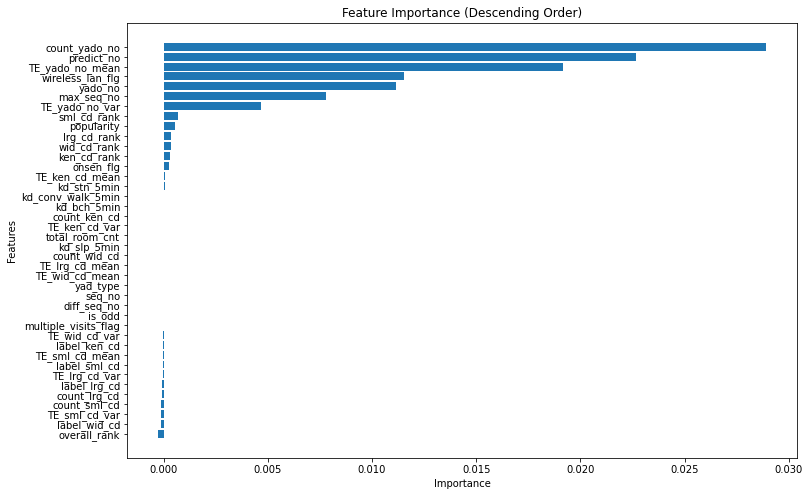

In [7]:
import matplotlib.pyplot as plt

# トレーニングデータセットでのPoolを作成（もしまだ作成していない場合）
#train_pool = Pool(data=train_data[features], label=train_data[target], group_id=train_data[query_ids])

# 特徴量の重要度を取得（トレーニングデータセットを使用）
feature_importances = model.get_feature_importance(train_pool, prettified=True)

# 特徴量の重要度を降順に並び替え
feature_importances.sort_values(by='Importances', ascending=False, inplace=True)

# 特徴量の重要度を表示
print(feature_importances)

# 特徴量の重要度をグラフで表示（降順）
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature Id'], feature_importances['Importances'])
plt.gca().invert_yaxis()  # y軸を逆順にして、重要度が高い特徴量を上に表示
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance (Descending Order)')
plt.show()



In [8]:
# train_dfのyado_noをyad_noに変更
train_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [9]:
train_df['oof_pred'] = oof_pred
train_df[['session_id', 'yad_no', 'oof_pred']].head()

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.389027
1,000125c737df1802b6e365f93c96d3c8,441,-0.029470
2,000125c737df1802b6e365f93c96d3c8,2480,0.270769
3,000125c737df1802b6e365f93c96d3c8,13240,0.125693
4,000125c737df1802b6e365f93c96d3c8,10378,0.179511


In [10]:
train_df[['session_id', 'yad_no', 'oof_pred']]

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.389027
1,000125c737df1802b6e365f93c96d3c8,441,-0.029470
2,000125c737df1802b6e365f93c96d3c8,2480,0.270769
3,000125c737df1802b6e365f93c96d3c8,13240,0.125693
4,000125c737df1802b6e365f93c96d3c8,10378,0.179511
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.835616
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.369929
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.727708
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.305817


In [11]:
oof_pred_df = train_df[['session_id', 'yad_no', 'oof_pred']]
oof_pred_df

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.389027
1,000125c737df1802b6e365f93c96d3c8,441,-0.029470
2,000125c737df1802b6e365f93c96d3c8,2480,0.270769
3,000125c737df1802b6e365f93c96d3c8,13240,0.125693
4,000125c737df1802b6e365f93c96d3c8,10378,0.179511
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.835616
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.369929
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.727708
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.305817


In [12]:
# アンサンブル用にoof_predを保存
oof_pred_df.to_csv('../ensemble/catRanker_ver8_oof_pred.csv', index=False)

In [13]:
oof_pred_df

,session_id,yad_no,oof_pred
0,000125c737df1802b6e365f93c96d3c8,7531,0.389027
1,000125c737df1802b6e365f93c96d3c8,441,-0.029470
2,000125c737df1802b6e365f93c96d3c8,2480,0.270769
3,000125c737df1802b6e365f93c96d3c8,13240,0.125693
4,000125c737df1802b6e365f93c96d3c8,10378,0.179511
...,...,...,...
2777522,fffe8a472ae6a96c9da05a30ac3ed6c5,4772,-2.835616
2777523,fffe8a472ae6a96c9da05a30ac3ed6c5,1482,-2.369929
2777524,fffe8a472ae6a96c9da05a30ac3ed6c5,4116,-1.727708
2777525,fffe8a472ae6a96c9da05a30ac3ed6c5,10613,-3.305817


### CVの計算

In [14]:
train_log_df = pd.read_csv('../train_log.csv')
train_label_df = pd.read_csv('../train_label.csv')

In [15]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
oof_pred_df = oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
oof_pred_df.set_index('session_id', inplace=True)

In [16]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = '000104bdffaaad1a1e0a9ebacf585f33'
recommendations = get_top_recommendations(session_id_to_check, oof_pred_df)
print(recommendations)

[3894, 7749, 902, 11380, 1284, 5490, 254, 12491, 4072]
CPU times: user 155 ms, sys: 3.97 ms, total: 159 ms
Wall time: 158 ms


In [17]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = train_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = train_label_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(train_label_df))}
    for future in tqdm(as_completed(future_to_session), total=len(train_label_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 288698/288698 [00:42<00:00, 6763.36it/s]


In [18]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
result_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
result_df.columns = [f'predict_{i}' for i in range(result_df.shape[1])]
# 最初の列にセッションIDを追加する
# result_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
result_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,2808,4101,5289,997,12846,3324,11882,9208,9207,9209
1,8253,4488,2570,1586,3725,11104,8747,2259,8225,3564
2,4863,13642,5238,1967,9039,2957,6722,4355,7509,11724
3,626,755,109,13296,11715,13549,7812,7872,2272,1341
4,96,3894,7749,902,11380,1284,5490,254,12491,4072
...,...,...,...,...,...,...,...,...,...,...
288693,5719,13210,10522,13079,3725,1586,13717,10955,8677,2876
288694,513,2900,4767,963,399,8465,5299,6654,8703,3940
288695,3566,7820,10364,9558,2087,4398,844,12240,4040,7308
288696,10619,12500,570,11091,7551,3238,10616,12781,12829,11316


### 要素の集合にバグがないかを確認

In [19]:
candidate_ver15_train = pd.read_csv('../data/candidate_ver15_train.csv')

In [20]:
# 既存のDataFrameを読み込む
df1 = candidate_ver15_train
df2 = result_df#.drop(columns=['has_duplicates'])
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)


0


### 順位変動のあったカラムを確認する

In [21]:
candidate_ver15_train

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
...,...,...,...,...,...,...,...,...,...,...
288693,13210,13079,2876,3725,8677,13717,1586,10955,10522,5719
288694,8703,3940,399,4767,2900,6654,5299,8465,963,513
288695,7308,12240,4040,7820,4398,2087,9558,3566,844,10364
288696,10619,570,12500,11091,7551,3238,10616,12781,12829,11316


In [22]:
# 各要素が一致しているかどうかをチェック
diff = candidate_ver15_train != result_df

# 一致していない行のインデックスを抽出
mismatched_indices = diff.any(axis=1)
mismatched_rows = candidate_ver15_train[mismatched_indices]

print("一致していない行のインデックス：")
print(mismatched_indices)
print("一致していない行：")
print(len(mismatched_rows))

一致していない行のインデックス：
0         True
1         True
2         True
3         True
4         True
          ... 
288693    True
288694    True
288695    True
288696    True
288697    True
Length: 288698, dtype: bool
一致していない行：
287094


In [23]:
candidate_ver15_train[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,11882,2808,5289,4101,3324,12846,997,9207,9209,9208
1,8253,8747,2570,1586,11104,3725,4488,2259,3564,8225
2,9039,6722,7509,4355,4863,11724,5238,13642,1967,2957
3,626,755,11715,7812,109,2272,13296,1341,13549,7872
4,96,3894,7749,902,11380,5490,1284,12491,254,4072
5,10510,4823,12544,5369,1,9207,9199,9200,9201,9202
6,7531,441,2480,13240,10378,2282,7273,10442,12774,4574
7,4744,9508,7681,10362,12962,1755,12125,12464,111,10544
8,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
9,10478,379,550,3278,3483,6592,9773,9430,4303,2806


In [24]:
result_df[mismatched_indices].head(20)

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,2808,4101,5289,997,12846,3324,11882,9208,9207,9209
1,8253,4488,2570,1586,3725,11104,8747,2259,8225,3564
2,4863,13642,5238,1967,9039,2957,6722,4355,7509,11724
3,626,755,109,13296,11715,13549,7812,7872,2272,1341
4,96,3894,7749,902,11380,1284,5490,254,12491,4072
5,4823,12544,10510,5369,9207,9199,9200,9201,9202,1
6,4574,10442,7531,2480,10378,13240,12774,441,7273,2282
7,111,10362,10544,12464,4744,12125,12962,9508,7681,1755
8,13220,12432,3802,3644,2164,9723,4014,1227,899,13702
9,10478,6592,550,379,3483,9430,4303,3278,2806,9773


In [25]:
y_true = train_label['yad_no'].values.reshape(-1, 1)
y_pred = result_df.values

In [26]:
# Recall(候補にあげたものが)のy_trueに含まれているものの割合

# マッチするかどうかをチェックするリストを初期化
matches = []

# y_pred の各サブアレイと y_true の値を比較
for pred, true in zip(y_pred, y_true):
    # pred はサブアレイ、true は値
    matches.append(int(true in pred))

# matches は、指定された条件に基づいて 0 と 1 のリストです
print(matches)

# matches は先のステップで生成した 0 と 1 のリストです。
# 1 の割合を計算
one_ratio = sum(matches) / len(matches)

# 割合をプリント
print("Recall is: {:.2%}".format(one_ratio))

[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 

In [27]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the AP at k between two lists of items.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean AP at k between two lists of list of items.
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

# y_true と y_pred をリストに変換
y_true_list = [list(x) for x in y_true]
y_pred_list = [list(x) for x in y_pred]

# MAP@10 を計算
map_at_10 = mapk(y_true_list, y_pred_list, k=10)
print(f'Map@10  {map_at_10}')

Map@10  0.48391618962068006


In [28]:
# 各行内で重複があるかどうかをチェック
def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
result_df['has_duplicates'] = result_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = result_df[result_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [29]:
# 欠損がないかをチェック
result_df.isnull().sum(axis=1).sum()

0

In [30]:
result_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,2808,4101,5289,997,12846,3324,11882,9208,9207,9209,False
1,8253,4488,2570,1586,3725,11104,8747,2259,8225,3564,False
2,4863,13642,5238,1967,9039,2957,6722,4355,7509,11724,False
3,626,755,109,13296,11715,13549,7812,7872,2272,1341,False
4,96,3894,7749,902,11380,1284,5490,254,12491,4072,False


### 推論用の候補テーブルを作成する

In [31]:
test_log_df = pd.read_csv('../test_log.csv')
test_session_df = pd.read_csv('../test_session.csv')

In [32]:
print(np.mean(test_pred, axis=0))  # 各foldのテストデータの予測値の平均をとる
print(len(np.mean(test_pred, axis=0)))

[ 1.03313743  0.14608059  0.44295858 ... -0.00820794  0.14804111
  0.22477865]
1683604


In [33]:
# test_predの形を調べる
print(np.array(test_pred).shape)

(10, 1683604)


In [34]:
# test_dfのyado_noをyad_noに変更
test_df.rename(columns={'yado_no': 'yad_no'}, inplace=True)

In [35]:
test_df['target'] = np.mean(test_pred, axis=0)
test_df[['session_id', 'yad_no', 'target']].head()

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,1.033137
1,00001149e9c73985425197104712478c,4714,0.146081
2,00001149e9c73985425197104712478c,2680,0.442959
3,00001149e9c73985425197104712478c,4420,-0.612086
4,00001149e9c73985425197104712478c,5466,-0.452484


In [36]:
test_oof_pred_df = test_df[['session_id', 'yad_no', 'target']]
test_oof_pred_df

,session_id,yad_no,target
0,00001149e9c73985425197104712478c,11561,1.033137
1,00001149e9c73985425197104712478c,4714,0.146081
2,00001149e9c73985425197104712478c,2680,0.442959
3,00001149e9c73985425197104712478c,4420,-0.612086
4,00001149e9c73985425197104712478c,5466,-0.452484
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.107541
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.158528
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.008208
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.148041


In [37]:
# test_oof_pred_dfのカラム名を変更
test_oof_pred_df.rename(columns={'target': 'oof_pred'}, inplace=True)
test_oof_pred_df

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,1.033137
1,00001149e9c73985425197104712478c,4714,0.146081
2,00001149e9c73985425197104712478c,2680,0.442959
3,00001149e9c73985425197104712478c,4420,-0.612086
4,00001149e9c73985425197104712478c,5466,-0.452484
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.107541
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.158528
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.008208
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.148041


In [38]:
test_oof_pred_df

,session_id,yad_no,oof_pred
0,00001149e9c73985425197104712478c,11561,1.033137
1,00001149e9c73985425197104712478c,4714,0.146081
2,00001149e9c73985425197104712478c,2680,0.442959
3,00001149e9c73985425197104712478c,4420,-0.612086
4,00001149e9c73985425197104712478c,5466,-0.452484
...,...,...,...
1683599,ffffe984aafd6127ce8e43e3ca40c79d,5623,0.107541
1683600,ffffe984aafd6127ce8e43e3ca40c79d,3781,0.158528
1683601,ffffe984aafd6127ce8e43e3ca40c79d,11994,-0.008208
1683602,ffffe984aafd6127ce8e43e3ca40c79d,634,0.148041


In [39]:
# アンサンブル用にoof_predを保存
test_oof_pred_df.to_csv('../ensemble/catRanker_ver8_test_pred.csv', index=False)

In [40]:
import pandas as pd

# oof_pred_dfを事前に処理しておきます。
# ここで'session_id'にインデックスを設定し、'oof_pred'でソートします。
# これにより、フィルタリングとソートのコストを削減できます。
test_oof_pred_df = test_oof_pred_df.sort_values(['session_id', 'oof_pred'], ascending=[True, False])
test_oof_pred_df.set_index('session_id', inplace=True)

In [41]:
%%time
def get_top_recommendations(session_id, df):
    """
    この関数は指定されたsession IDに基づいて、推薦確率に基づいた宿泊施設のリストを返します。

    パラメータ:
    session_id (str): 推薦をフィルタリングするためのセッションID。
    df (pd.DataFrame): 推薦が含まれているDataFrame。

    戻り値:
    list: 推薦確率に基づいてソートされた宿泊施設ID(`yad_no`)のリスト。
    """
    try:
        # インデックスを使ってデータを取得
        recommendations = df.loc[session_id, 'yad_no']
        # Seriesオブジェクトの値をリストに変換
        return recommendations.values.tolist()
    except KeyError:
        # 指定されたsession_idが存在しない場合は空のリストを返す
        return []


# 使用例:
session_id_to_check = 'ffffe984aafd6127ce8e43e3ca40c79d'
recommendations = get_top_recommendations(session_id_to_check, test_oof_pred_df)
print(recommendations)

[11723, 12767, 1891, 12620, 3781, 634, 5623, 867, 11994, 10729]
CPU times: user 91.6 ms, sys: 3.91 ms, total: 95.5 ms
Wall time: 95.4 ms


In [42]:
# セッションIDごとに yad_no のリストを作成
session_yadno_map = test_log_df.groupby('session_id')['yad_no'].apply(list).to_dict() #ここをtrain, testで変える  train_log_df, test_log_df


def generate_recommendation(i):
    
    # 推薦する宿を格納するリスト
    pred_recommendations = []
    
    # 指定セッションの宿を抽出
    session_id = test_session_df.loc[i, 'session_id']  #ここをtrain, testで変える  train_label_df, test_session_df
    yado_no = session_yadno_map.get(session_id, [])
    last_yado = yado_no[-1] if yado_no else None
    yado_no = pd.Series(yado_no).drop_duplicates().tolist()
    
    pred_recommendations.extend(yado_no) # 最後に訪問された宿を除外
    if last_yado in pred_recommendations:
        pred_recommendations.remove(last_yado)
    
    # 各セッションのcandidateを並べ替えたもの
    sorted_covisitation = get_top_recommendations(session_id=session_id, df=test_oof_pred_df)
    pred_recommendations.extend(sorted_covisitation)

    return i, pred_recommendations[:10]


# マルチプロセス処理の実行
results = []
with ProcessPoolExecutor(max_workers=16) as executor: # ここのmax_workersは手持ちのCPUのスレッド数によって適宜変える
    future_to_session = {executor.submit(generate_recommendation, i): i for i in range(len(test_session_df))}
    for future in tqdm(as_completed(future_to_session), total=len(test_session_df), desc="Processing recommendations"):
        index = future_to_session[future]
        result = future.result()
        results.append((index, result))

results.sort(key=lambda x: x[0])
preds = [result for i, result in results]

Processing recommendations: 100%|██████████| 174700/174700 [00:26<00:00, 6536.68it/s]


In [43]:
submission_df = pd.DataFrame(preds)
submission_df
submission_df[1]

# 推薦リストを新しい列に展開する
test_expanded_df = submission_df[1].apply(pd.Series)
# 新しい列名を設定する
test_expanded_df.columns = [f'predict_{i}' for i in range(test_expanded_df.shape[1])]
# 最初の列にセッションIDを追加する
# expanded_df.insert(0, 'session_id', submission_df.index)
# 展開されたDataFrameを表示
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,2680,4714,5466,9830,4420,9534,6563,5785
1,143,7014,613,8108,11923,6555,4066,6129,11237,12862
2,757,9190,7710,9910,1774,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,6489,10746
4,10826,9020,9623,3476,2862,3854,12029,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,2278,10997,10042,3440,9743
174696,13702,1227,4014,3802,2164,12432,13220,899,9723,3644
174697,13241,13719,2087,13797,5810,7308,12939,11037,11796,8143
174698,3100,10287,3002,2373,2692,1687,13672,5513,4976,12281


In [45]:
# 各行内で重複があるかどうかをチェック

def check_row_duplicates(row):
    # setを用いてユニークな要素のみを抽出し、その長さが元の行の長さと等しいかを比較
    return len(row) != len(set(row))
# check_row_duplicates関数を各行に適用し、結果を新しい列に格納
test_expanded_df['has_duplicates'] = test_expanded_df.apply(check_row_duplicates, axis=1)
# 重複がある行のみをフィルタリング
rows_with_duplicates = test_expanded_df[test_expanded_df['has_duplicates']]
# 結果を表示
print(len(rows_with_duplicates))

0


In [46]:
# 欠損がないかをチェック
test_expanded_df.isnull().sum(axis=1).sum()

0

In [47]:
candidate_ver15_test = pd.read_csv('../data/candidate_ver15_test.csv')
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [48]:
# 行ごとに要素の集合が異なっていないかをチェック
import pandas as pd

# 既存のDataFrameを読み込む
df1 = candidate_ver15_test
df2 = test_expanded_df.drop('has_duplicates', axis=1)
# 各行を集合として保存するリストを初期化
sets_in_df1 = [set(row) for index, row in df1.iterrows()]
sets_in_df2 = [set(row) for index, row in df2.iterrows()]

# 互いに異なる行の件数をカウントする
unique_count = sum(1 for set1, set2 in zip(sets_in_df1, sets_in_df2) if set1 != set2)

# 結果を出力
print(unique_count)

0


In [49]:
candidate_ver15_test

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,3560,11561,4714,2680,4420,5466,9830,9534,6563,5785
1,143,4066,6555,7014,11923,8108,6129,613,11237,12862
2,757,9190,7710,1774,9910,10485,6721,410,13570,6730
3,12341,3359,6991,1542,13521,5080,10861,4180,10746,6489
4,9020,2862,10826,12029,3854,3476,9623,3844,5372,6161
...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,10997,7062,9743,2278,10042,3440
174696,13220,12432,899,4014,3802,1227,3644,2164,13702,9723
174697,13241,13797,13719,12939,7308,2087,8143,11796,11037,5810
174698,3100,10287,3002,2373,12281,4976,13672,2692,5513,1687


In [50]:
test_expanded_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9,has_duplicates
0,3560,11561,2680,4714,5466,9830,4420,9534,6563,5785,False
1,143,7014,613,8108,11923,6555,4066,6129,11237,12862,False
2,757,9190,7710,9910,1774,10485,6721,410,13570,6730,False
3,12341,3359,6991,1542,13521,5080,10861,4180,6489,10746,False
4,10826,9020,9623,3476,2862,3854,12029,3844,5372,6161,False
...,...,...,...,...,...,...,...,...,...,...,...
174695,1997,7888,5744,11123,7062,2278,10997,10042,3440,9743,False
174696,13702,1227,4014,3802,2164,12432,13220,899,9723,3644,False
174697,13241,13719,2087,13797,5810,7308,12939,11037,11796,8143,False
174698,3100,10287,3002,2373,2692,1687,13672,5513,4976,12281,False


In [51]:
test_expanded_df.drop(columns=['has_duplicates']).to_csv('../submissions/catRanker_ver8.csv', index=False)